In [5]:
import pandas as pd
import talib as ta
import numpy as np


def preprocess_data(
    z_: pd.DataFrame,
    ret_periods: int = 24,
    vol_window: int = 24,
    atr_period: int = 14,
) -> pd.DataFrame:
    """数据预处理：计算收益率、波动率、ATR（小时级可调）"""
    z = z_.copy()
    z['ret'] = z['close'].pct_change().fillna(0)

    # 小时级：默认用近1天(24小时)的动量与波动率衡量信号强度
    z['rolling_ret'] = z['close'].pct_change(periods=ret_periods).fillna(0)
    z['rolling_vol'] = z['ret'].rolling(window=vol_window).std().fillna(1e-6)
    z['signal_strength'] = z['rolling_ret'] / z['rolling_vol']

    z['atr'] = ta.ATR(z['high'], z['low'], z['close'], timeperiod=atr_period)
    z['position'] = 0.0
    z['flag'] = 0.0
    return z


def run_strategy(
    z: pd.DataFrame,
    signal_threshold: float = 0.3,
    atr_stop_mult: float = 1.5,
    tp_drawdown_pct: float = 0.05,
    ret_periods: int = 24,
    vol_window: int = 24,
    atr_period: int = 14,
) -> tuple:
    """以小时为单位的策略：较低阈值与更紧风控"""
    Buy, Sell = [], []
    max_price = 0.0
    atr_entry = 0.0
    price_in = 0.0

    i_start = max(ret_periods, vol_window, atr_period)
    for i in range(i_start, len(z)):
        signal = z['signal_strength'].iloc[i]

        # 开仓：信号强度 > 阈值
        if z['position'].iloc[i - 1] == 0 and signal > signal_threshold:
            z.at[z.index[i], 'flag'] = 1
            z.at[z.index[i], 'position'] = 1
            price_in = z['close'].iloc[i]
            date_in = z.index[i]
            atr_entry = z['atr'].iloc[i]
            max_price = z['close'].iloc[i]
            Buy.append([date_in, price_in, f'开仓: signal={signal:.2f}, ATR={atr_entry:.2f}'])
            print(z.index[i], f'【开仓】信号={signal:.2f}，ATR={atr_entry:.2f}')

        # 有仓位：检查止损/止盈
        elif z['position'].iloc[i - 1] == 1:
            current_price = z['close'].iloc[i]
            max_price = max(max_price, current_price)
            floating_profit = (current_price - price_in) / price_in
            floating_drawdown = (max_price - current_price) / max_price if max_price != 0 else 0.0
            drawdown_atr = price_in - current_price

            # 止损：跌幅超过 ATR 倍数（更紧）
            if drawdown_atr > atr_stop_mult * atr_entry:
                z.at[z.index[i], 'flag'] = -1
                z.at[z.index[i], 'position'] = 0
                price_out = z['close'].iloc[i]
                date_out = z.index[i]
                Sell.append([date_out, price_out, f'止损: 跌幅={drawdown_atr:.2f} > {atr_stop_mult}ATR={atr_stop_mult*atr_entry:.2f}'])
                print(z.index[i], f'【止损】当前价格较开仓价下跌{drawdown_atr:.2f} > {atr_stop_mult}ATR')

            # 止盈：从最高点回撤超过阈值（更紧，如5%）
            elif floating_profit > 0 and floating_drawdown > tp_drawdown_pct:
                z.at[z.index[i], 'flag'] = -1
                z.at[z.index[i], 'position'] = 0
                price_out = z['close'].iloc[i]
                date_out = z.index[i]
                Sell.append([date_out, price_out, f'止盈: 回撤={floating_drawdown:.2%}'])
                print(z.index[i], f'【止盈】浮盈回撤={floating_drawdown:.2%} > {tp_drawdown_pct:.0%}')

            else:
                z.at[z.index[i], 'position'] = z['position'].iloc[i - 1]
                print(z.index[i], f'持仓中，当前浮盈={floating_profit:.2%}')

    # 交易记录整理
    p1 = pd.DataFrame(Buy, columns=['买入日期', '买入价格', '备注'])
    p2 = pd.DataFrame(Sell, columns=['卖出日期', '卖出价格', '备注'])
    transaction = pd.concat([p1, p2], axis=1)

    # 净值计算
    z['ret'] = z['close'].pct_change().fillna(0)
    effective_position = z['position'].shift(1).fillna(0)  # 用前一根K线的仓位
    z['nav'] = (1 + z['ret'] * effective_position).cumprod()
    z['benchmark'] = z['close'] / z['close'].iloc[0]


    return z, transaction


In [6]:
import crypto_process
start_month = '2022-01'
end_month = '2023-03'
# 按小时回测
freq = '1h'

z_original = crypto_process.load_data(start_month, end_month)
z_resampled = crypto_process.resample_data(z_original, freq)

# 小时级预处理参数可调（默认 24 小时窗口）
z = preprocess_data(z_resampled, ret_periods=24, vol_window=24, atr_period=14)

# 运行策略：小时级阈值更紧
params = dict(signal_threshold=0.3, atr_stop_mult=1.5, tp_drawdown_pct=0.05,
              ret_periods=24, vol_window=24, atr_period=14)
data_price, transaction = run_strategy(z, **params) 

成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2022-01.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (44640, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2022-02.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (40320, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2022-03.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (44640, 12)
成功读取文件: D:/workspace/data/crypto/1min/BTCUSDT/BTCUSDT-1m-2022-04.zip
列名: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
数据形状: (43200, 12)
成功读取文件: D:/workspace/data/crypto

C:\Users\youdo\AppData\Local\Temp\ipykernel_46736\3171547690.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z['ret'] = z['close'].pct_change().fillna(0)
C:\Users\youdo\AppData\Local\Temp\ipykernel_46736\3171547690.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z['rolling_ret'] = z['close'].pct_change(periods=ret_periods).fillna(0)


2022-01-02 00:00:00 【开仓】信号=4.60，ATR=383.85
2022-01-02 01:00:00 持仓中，当前浮盈=-0.52%
2022-01-02 02:00:00 持仓中，当前浮盈=-0.54%
2022-01-02 03:00:00 持仓中，当前浮盈=-0.62%
2022-01-02 04:00:00 【止损】当前价格较开仓价下跌715.00 > 1.5ATR
2022-01-02 06:00:00 【开仓】信号=0.67，ATR=356.18
2022-01-02 07:00:00 持仓中，当前浮盈=0.11%
2022-01-02 08:00:00 持仓中，当前浮盈=0.21%
2022-01-02 09:00:00 持仓中，当前浮盈=0.32%
2022-01-02 10:00:00 持仓中，当前浮盈=0.14%
2022-01-02 11:00:00 持仓中，当前浮盈=0.24%
2022-01-02 12:00:00 持仓中，当前浮盈=0.36%
2022-01-02 13:00:00 持仓中，当前浮盈=0.03%
2022-01-02 14:00:00 持仓中，当前浮盈=-0.02%
2022-01-02 15:00:00 持仓中，当前浮盈=0.46%
2022-01-02 16:00:00 持仓中，当前浮盈=1.42%
2022-01-02 17:00:00 持仓中，当前浮盈=0.59%
2022-01-02 18:00:00 持仓中，当前浮盈=-0.14%
2022-01-02 19:00:00 持仓中，当前浮盈=-0.46%
2022-01-02 20:00:00 持仓中，当前浮盈=-0.25%
2022-01-02 21:00:00 持仓中，当前浮盈=-0.22%
2022-01-02 22:00:00 持仓中，当前浮盈=0.28%
2022-01-02 23:00:00 持仓中，当前浮盈=0.35%
2022-01-03 00:00:00 持仓中，当前浮盈=-0.15%
2022-01-03 01:00:00 持仓中，当前浮盈=-0.01%
2022-01-03 02:00:00 持仓中，当前浮盈=-0.26%
2022-01-03 03:00:00 持仓中，当前浮盈=-0.70%
2022-01-03 0

C:\Users\youdo\AppData\Local\Temp\ipykernel_46736\3171547690.py:93: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  z['ret'] = z['close'].pct_change().fillna(0)


<Axes: xlabel='open_time'>

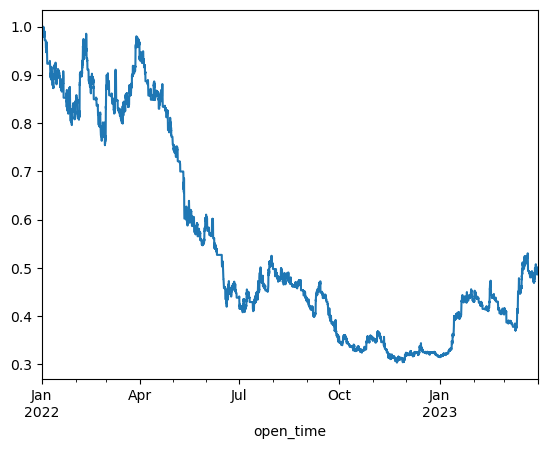

In [7]:
data_price.nav.plot()


In [8]:
data_price

,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ret,rolling_ret,rolling_vol,signal_strength,atr,position,flag,nav,benchmark
open_time,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,46216.93,46731.39,46208.37,46656.13,1503.33095,6.987999e+07,38608,806.06536,3.746216e+07,0.000000,0.000000,0.000001,0.000000,NaN,0.0,0.0,1.000000,1.000000
2022-01-01 01:00:00,46656.14,46949.99,46574.06,46778.14,943.81539,4.412715e+07,31872,491.18067,2.296327e+07,0.002615,0.000000,0.000001,0.000000,NaN,0.0,0.0,1.000000,1.002615
2022-01-01 02:00:00,46778.14,46928.94,46721.96,46811.77,485.16860,2.272067e+07,24364,206.35113,9.662607e+06,0.000719,0.000000,0.000001,0.000000,NaN,0.0,0.0,1.000000,1.003336
2022-01-01 03:00:00,46811.77,46916.63,46760.12,46813.20,562.88971,2.636326e+07,19882,248.28212,1.162938e+07,0.000031,0.000000,0.000001,0.000000,NaN,0.0,0.0,1.000000,1.003367
2022-01-01 04:00:00,46813.21,46887.33,46591.23,46711.05,861.88389,4.027204e+07,23357,397.53563,1.857540e+07,-0.002182,0.000000,0.000001,0.000000,NaN,0.0,0.0,1.000000,1.001177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,28315.49,28524.12,28279.24,28469.31,2766.38020,7.859050e+07,49983,1422.70488,4.041139e+07,0.005432,0.017266,0.004923,3.507033,NaN,1.0,0.0,0.498696,0.610194
2023-03-31 20:00:00,28469.31,28474.06,28337.46,28391.80,1926.97706,5.474164e+07,45090,927.61079,2.635158e+07,-0.002723,0.008597,0.004846,1.774094,NaN,1.0,0.0,0.497338,0.608533
2023-03-31 21:00:00,28391.80,28590.00,28363.68,28477.19,1448.13203,4.122204e+07,37915,814.20583,2.318285e+07,0.003008,0.014560,0.004823,3.019013,NaN,1.0,0.0,0.498834,0.610363


In [9]:
import trading_analysis
analysis_results = trading_analysis.comprehensive_trading_analysis(transaction, data_price)
trading_analysis.print_trading_analysis(analysis_results)


交易策略综合分析报告

【基础交易统计】
交易总次数: 138
盈利交易次数: 26
亏损交易次数: 112
胜率: 18.84%

【利润率分析】
总利润率: -56.84%
平均利润率: -0.41%
最大单笔利润率: 37.02%
最大单笔亏损率: -5.44%
盈亏比: 3.26

【持仓时间分析】
平均持仓时间: 57.7 小时 (2.4 天)
最短持仓时间: 1.0 小时
最长持仓时间: 733.0 小时
短期交易占比: 47.8%
中期交易占比: 45.7%
长期交易占比: 5.8%

【连续性分析】
最大连续盈利次数: 2
最大连续亏损次数: 13

【交易频率分析】
日均交易次数: 0.31
周均交易次数: 2.16
月均交易次数: 9.26

【风险指标】
收益标准差: 5.20%
变异系数: 12.54
索提诺比率: -0.41

【利润率分布】
  小亏损(-5%~0%): 109 次
  小盈利(0%~5%): 13 次
  较大盈利(5%~10%): 7 次
  大盈利(>10%): 6 次
  较大亏损(-10%~-5%): 2 次
  严重亏损(<-10%): 0 次

【综合评估】
综合评分: 26.5/100
评估等级: 较差


In [ ]:
def calculate_performance_metrics(data_price: pd.DataFrame, transactions: pd.DataFrame) -> pd.DataFrame:
    """计算绩效指标（小时年化）"""
    N = 24 * 365  # 小时级年化因子
    rf = 0.02  # 年化无风险收益率

    # 年化收益率（按小时净值序列年化）
    rety = data_price.nav.iloc[-1] ** (N / data_price.shape[0]) - 1

    # 夏普比率（小时收益×仓位）
    strategy_returns = (data_price.ret * data_price.position).fillna(0)
    sharpe = (strategy_returns.mean() * N - rf) / (strategy_returns.std() * np.sqrt(N)) if strategy_returns.std() > 0 else np.nan

    # 胜率（仅在有成对买卖记录时有效）
    try:
        VictoryRatio = ((transactions['卖出价格'] - transactions['买入价格']) > 0).mean()
    except Exception:
        VictoryRatio = np.nan

    # 最大回撤
    DD = 1 - data_price.nav / data_price.nav.cummax()
    MDD = DD.max()

    # 月均交易次数（按小时：每月约 24*30 小时）
    trade_count = data_price.flag.abs().sum() / data_price.shape[0] * (24 * 30)

    result = {
        'Sharpe': sharpe,
        'Annual_Return': rety,
        'MDD': MDD,
        'Winning_Rate': VictoryRatio,
        'Trading_Num': round(trade_count, 1)
    }
    return pd.DataFrame(result, index=[0])


In [ ]:
result = calculate_performance_metrics(data_price,transaction)

In [ ]:
result

In [ ]:
flag = z['flag']

In [ ]:
price_ = z[['close','high','low','open']]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(z.index, z['close'], label='Close')

# 标记开仓和平仓点
ax.scatter(z[z['flag'] == 1].index, z[z['flag'] == 1]['close'], marker='^', color='red', label='Buy', s=100)
ax.scatter(z[z['flag'] == -1].index, z[z['flag'] == -1]['close'], marker='v', color='green', label='Sell', s=100)

ax.legend()
plt.title("trading signal")
plt.grid(True)
plt.show()


In [ ]:
# 1.掌握事件触发回测框架
# 2.理解复利和单利的区别